Comparaison de différentes méthodes pour la prédiction. Les méthodes réalisées sont :
10 méthodes

*   Logistic regression
*   LightGBM
*   Random Forest
*   Extratree Classifier
*   Xgboost
*   ANN
*   Sequential Neural Network
*   catboost classification
*   SVM
*   SVM ensemble
*   ...




In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import Sequential
from tensorflow.keras.activations import sigmoid, relu
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential #Helps to create Forward and backward propogation
from tensorflow.keras.layers import Dense #Helps to create neurons in ANN
from tensorflow.keras.layers import LeakyReLU,PReLU,ELU #activation functions

from xgboost import XGBClassifier

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import BaggingClassifier

import catboost as cat

import lightgbm as lgb

plt.rcParams['text.usetex'] = False
plt.rcParams.update({'font.size': 9})

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Preprocessing

In [ ]:
# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/CoursITS3/VTI - Mellouk/article final/Heart_disease_cleveland_new.csv")

In [ ]:
df.head() #target=1 : presence of the disease/ target = 0 : no disease

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2,0
1,67,1,3,160,286,0,2,108,1,1.5,1,3,1,1
2,67,1,3,120,229,0,2,129,1,2.6,1,2,3,1
3,37,1,2,130,250,0,0,187,0,3.5,2,0,1,0
4,41,0,1,130,204,0,2,172,0,1.4,0,0,1,0


In [ ]:
X=df.iloc[:,0:13]
y=df['target']
y.value_counts() ## Concludes data is not much unbalanced

0    164
1    139
Name: target, dtype: int64

In [ ]:
X.head(1)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,63,1,0,145,233,1,2,150,0,2.3,2,0,2


In [ ]:
def manage_null(df,feature='',handle=''):

    feature_names = list(df.columns.values)
    feature_index = feature_names.index(feature)

    if handle == 'drop':
        # drop the column named 'feature'
        mod_df = df.drop(feature, inplace=False, axis=1)
    elif handle == 'mode':
        # replace null entries in column number == feature_index with the mode within the same column.
        mod_df = df.fillna(df.iloc[:,feature_index].mode()[0], inplace=False)
    elif handle == 'mean':
        # replace null entries in column number == feature_index with the mean value of the column.
        mod_df = df.fillna(df.iloc[:,feature_index].mean(), inplace=False)
    else:
        print(f"Handle {handle} not found.")
        return df

    return mod_df

In [ ]:
df.thal = df.thal.replace(0,np.NaN)
df = manage_null(df,'thal','mode')
df.tail()
df.shape

(303, 14)

# Data Visualization

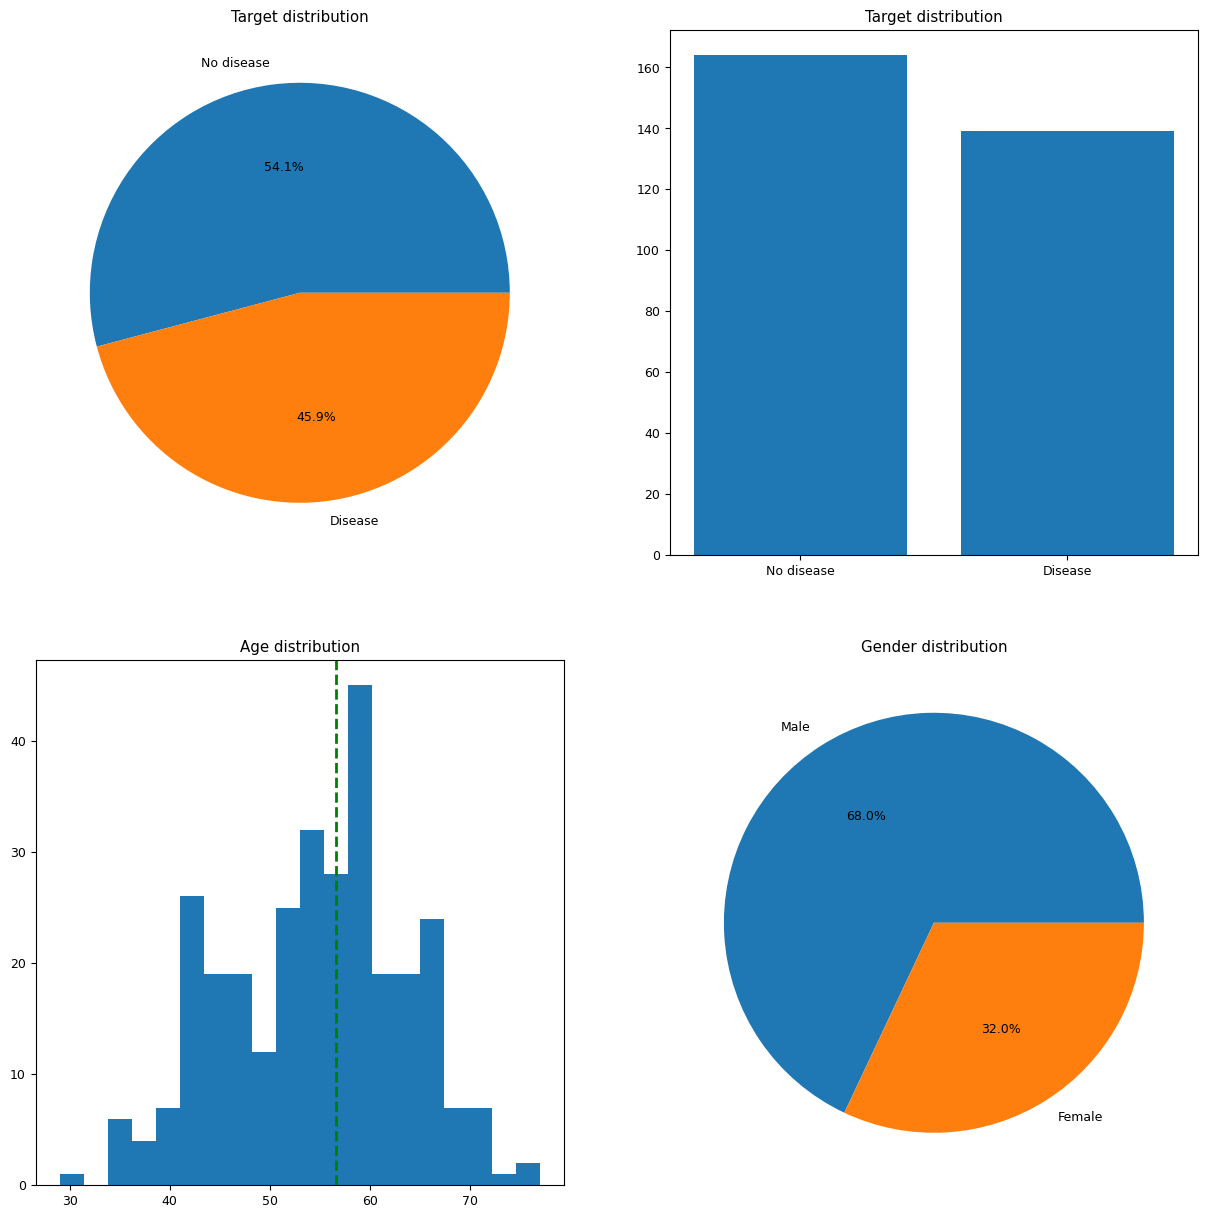

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(15,15))

target_counts = df['target'].value_counts()
axs[0, 0].pie(target_counts, labels=['No disease', 'Disease'], autopct='%1.1f%%')
axs[0, 0].set_title('Target distribution')

target_counts = df.groupby('target').count()['age']
axs[0, 1].bar(['No disease', 'Disease'], target_counts)
axs[0, 1].set_title('Target distribution')

age_counts = df['age'].value_counts()
axs[1, 0].hist(df['age'], bins=20)
axs[1, 0].axvline(x=df[df['target']==1]['age'].mean(), color='green', linestyle='dashed', linewidth=2)
axs[1, 0].set_title('Age distribution')

sex_counts = df['sex'].value_counts()
axs[1, 1].pie(sex_counts, labels=['Male', 'Female'], autopct='%1.1f%%')
axs[1, 1].set_title('Gender distribution')

plt.show()

In [ ]:
df_1=df[df['target']==1]
df_0=df[df['target']==0]

mean_values_0 = df_0[['trestbps', 'chol', 'thalach', 'oldpeak', 'ca']].mean()
mean_values_1 = df_1[['trestbps', 'chol', 'thalach', 'oldpeak', 'ca']].mean()

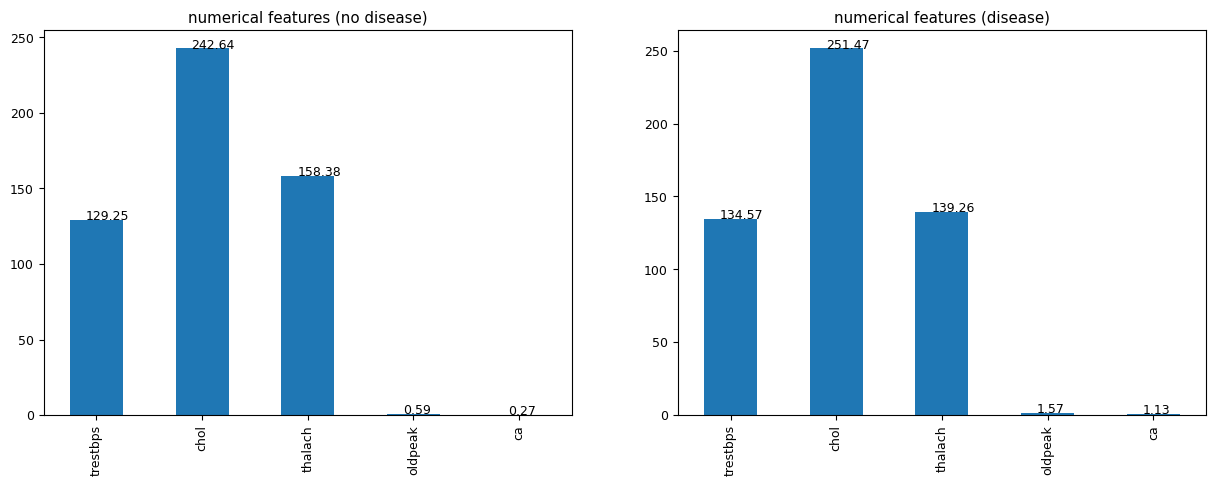

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
mean_values_0.plot(kind='bar', ax=axs[0])
for i, v in enumerate(mean_values_0):
    axs[0].text(i-0.1, v+0.1, str(round(v,2)))
    axs[0].set_title('numerical features (no disease)')

mean_values_1.plot(kind='bar', ax=axs[1])
for i, v in enumerate(mean_values_1):
    axs[1].text(i-0.1, v+0.1, str(round(v,2)))
    axs[1].set_title('numerical features (disease)')

plt.show()

In [ ]:
classes = np.unique(df.iloc[:,-1].values)
feature_names = list(df.columns.values) #13 features
feature_names.pop() # drop the last item, i.e. 'target', from the list

x = df.iloc[:,:-1].values
y = df.iloc[:,-1].values
y = y.reshape(-1,1)
print(feature_names)

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


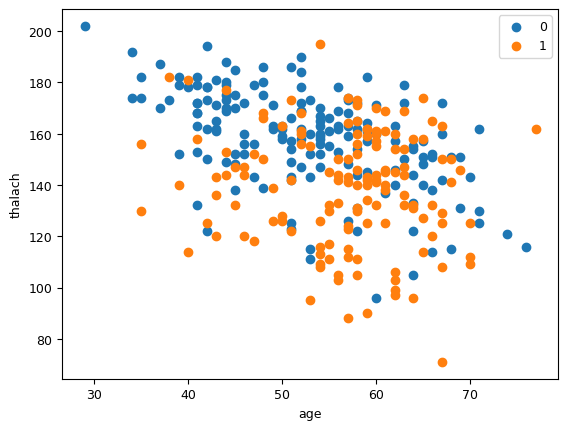

In [ ]:
fig, ax = plt.subplots()
for cl in range(len(classes)):
    ax.scatter(df[feature_names[0]].loc[df["target"]==cl],
              df[feature_names[7]].loc[df["target"]==cl],
              label=classes[cl])
ax.set_xlabel(feature_names[0])
ax.set_ylabel(feature_names[7])
ax.legend(loc='upper right')

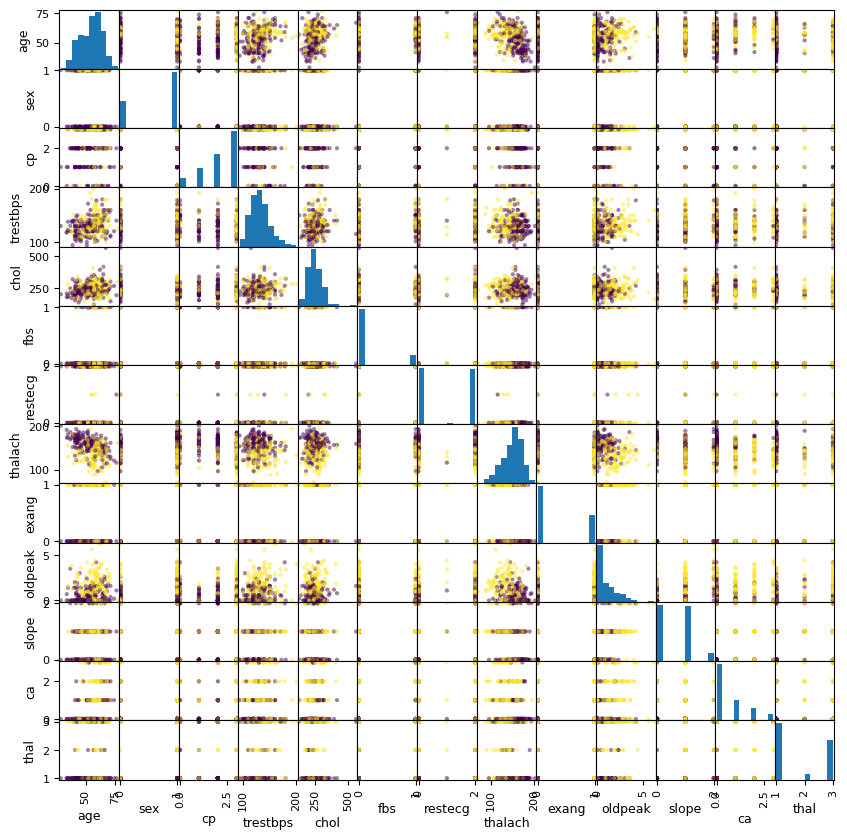

In [ ]:
df_ = pd.DataFrame(x, columns=feature_names)
axs = pd.plotting.scatter_matrix(df_,c=y,figsize=(10, 10))

<Axes: >

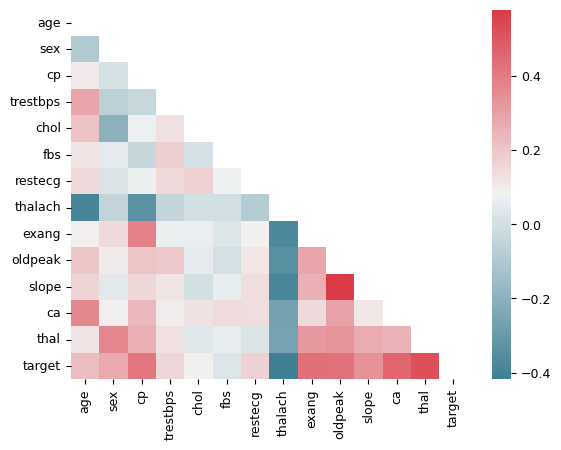

In [ ]:
corr_matrix = df.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=0)
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap)

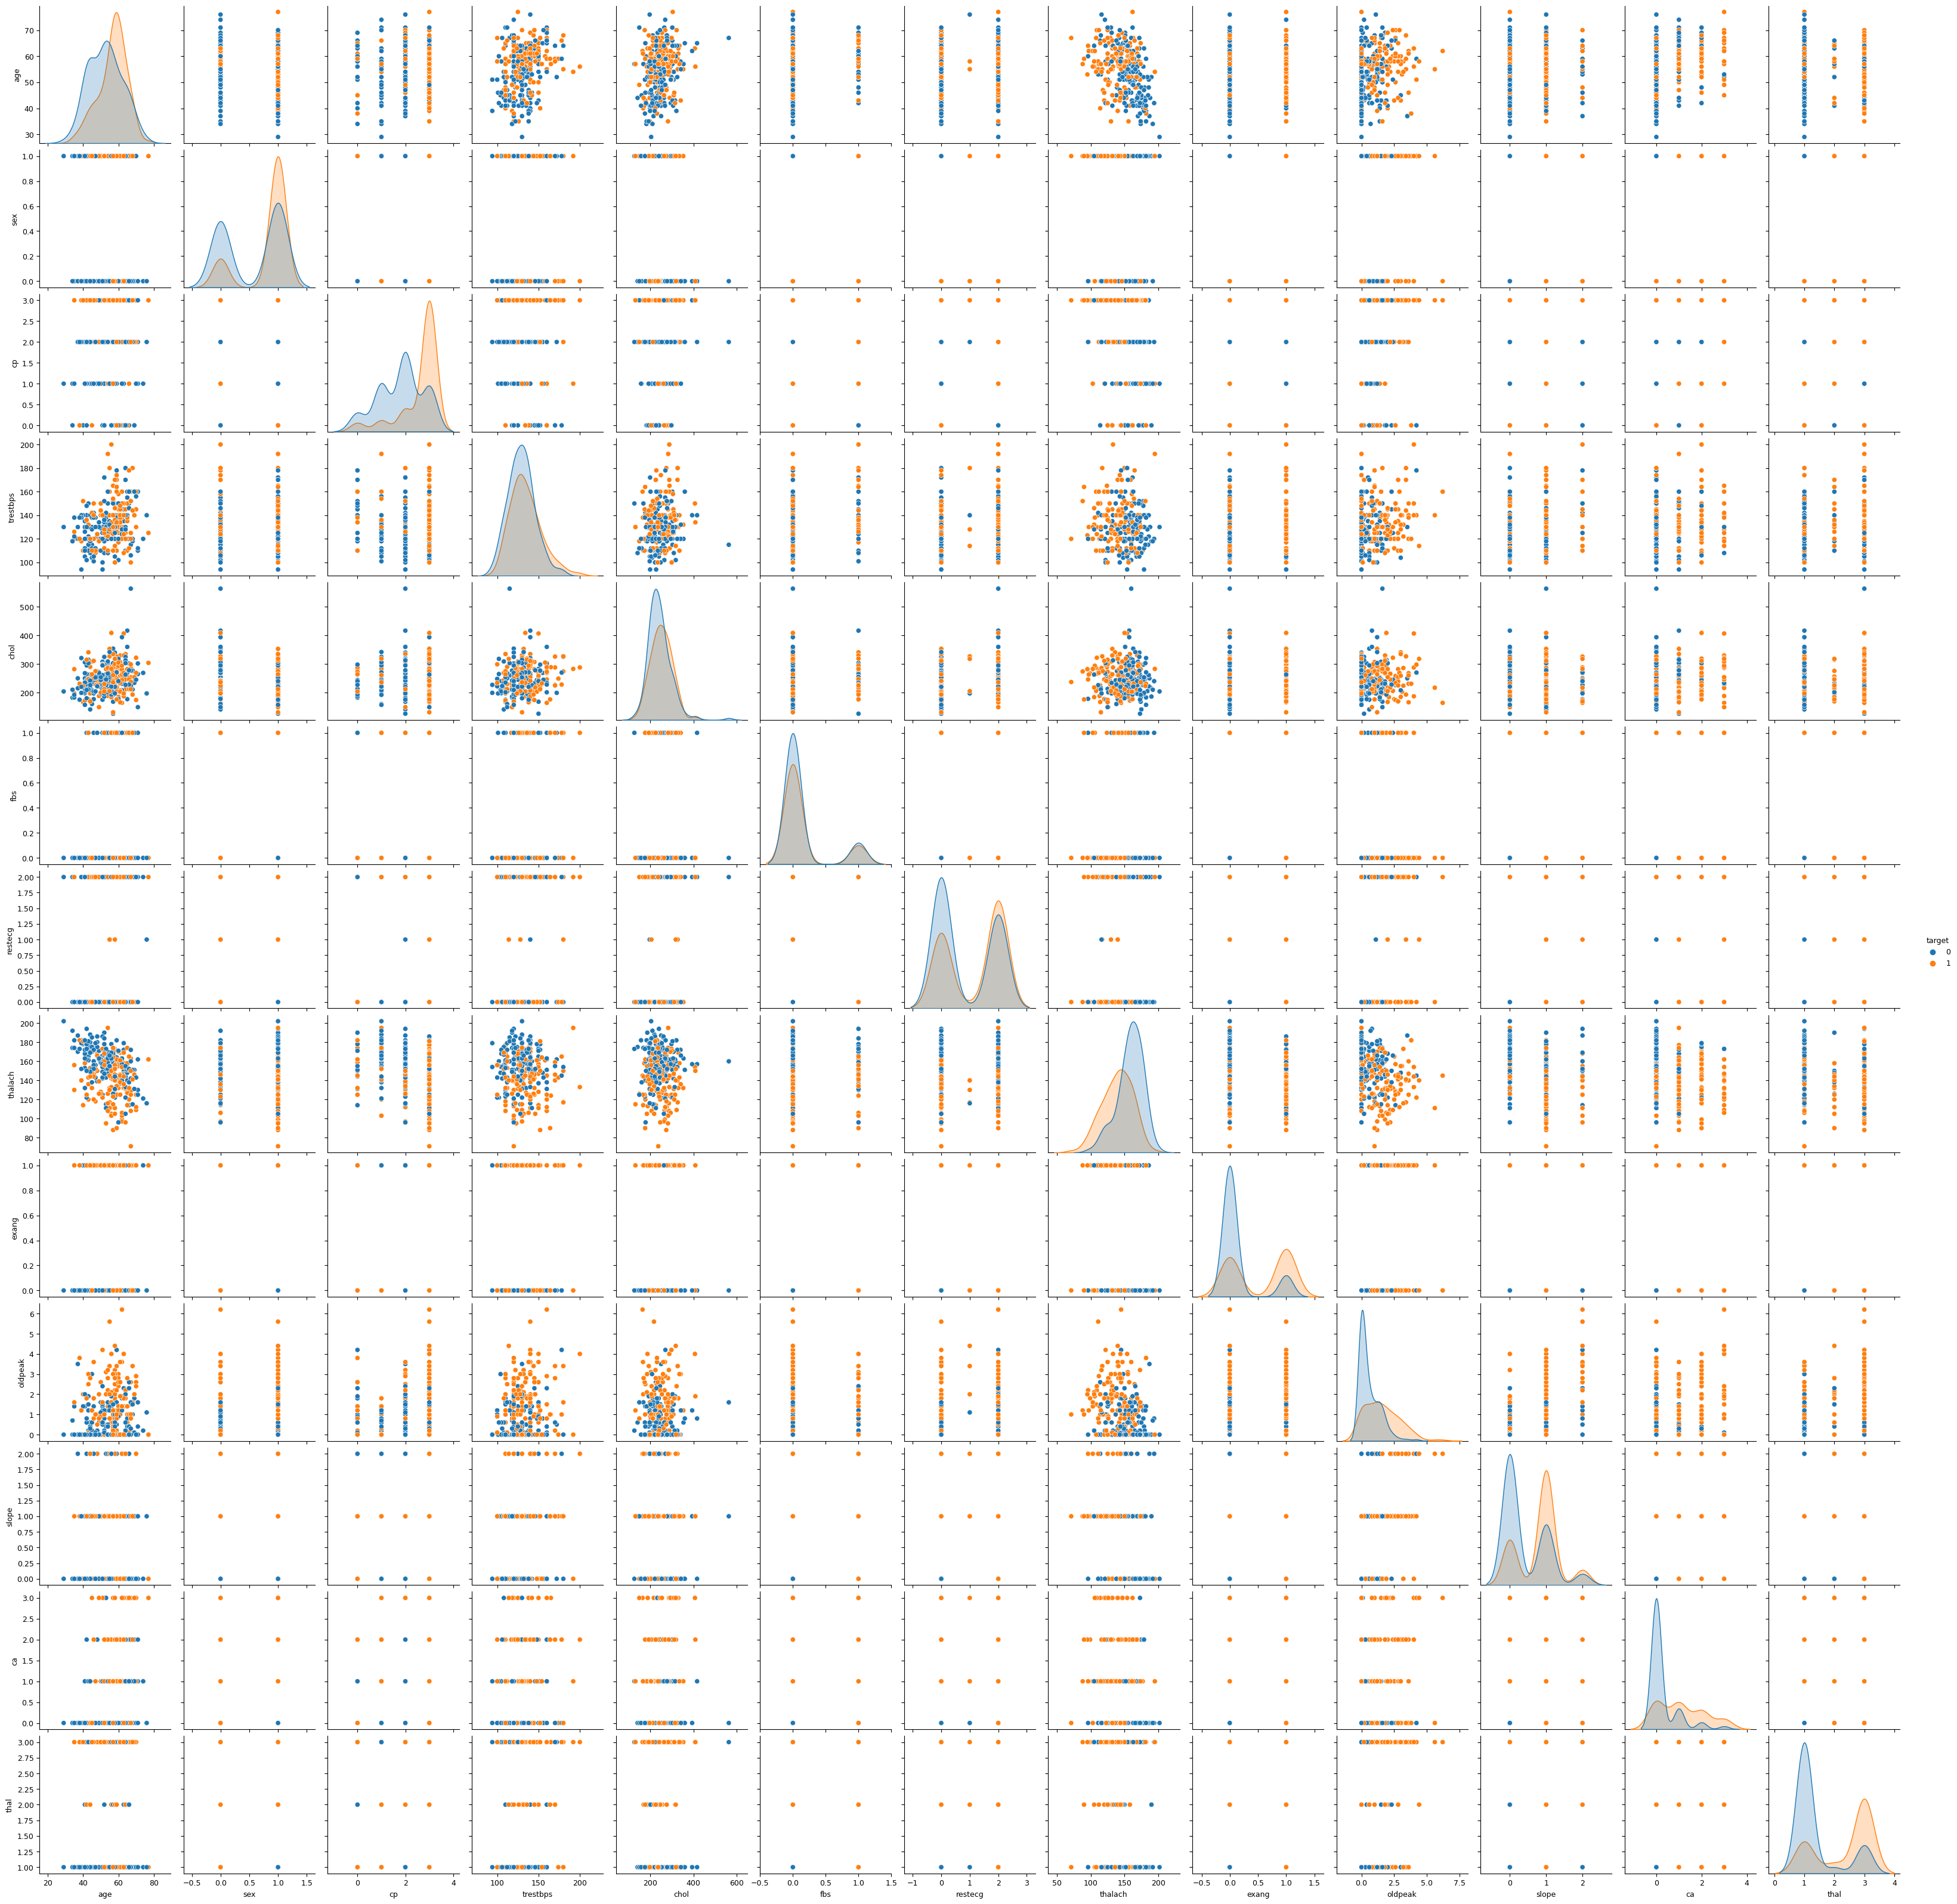

In [ ]:
sns.pairplot(df, hue = 'target')

# Split train/test set

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# ML/DL

## Logistic Regression

In [ ]:
logModel=LogisticRegression(solver='lbfgs', max_iter=10000)
logModel.fit(X_train, y_train)
predictions = logModel.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)*100

86.0

## LightGBM

In [ ]:
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
y_pred=clf.predict(X_test)
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)*100))

[LightGBM] [Info] Number of positive: 90, number of negative: 113
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 203, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.443350 -> initscore=-0.227578
[LightGBM] [Info] Start training from score -0.227578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


## Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators = 100)

# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
clf.fit(X_train, y_train)

# performing predictions on the test dataset
y_pred8 = clf.predict(X_test)
 # metrics are used to find accuracy or error
from sklearn import metrics
print()

# using metrics module for accuracy calculation
print( metrics.accuracy_score(y_test, y_pred8)*100)


85.0


## Extratree Classifier

In [ ]:
clf = ExtraTreesClassifier(n_estimators=100,max_depth=6,min_samples_split=2,min_weight_fraction_leaf =0.0,n_jobs=-1)
clf.fit(X_train, y_train)
print(clf.score(X_test, y_test)*100)
y_pred9 = clf.predict(X_test)

84.0


## Xgboost

In [ ]:
model = XGBClassifier(eval_metric='mlogloss')
model.fit(X_train, y_train)
y_pred1 = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred1)
print(accuracy*100)

82.0


## ANN

In [ ]:
classifier=Sequential()
classifier.add(Dense(units=11,activation='relu'))
classifier.add(Dense(units=7,activation='relu'))
classifier.add(Dense(units=6,activation='relu'))
## Adding the output layer
classifier.add(Dense(units=1,activation='sigmoid'))
classifier.compile(optimizer='adam',loss="binary_crossentropy",metrics=["accuracy"])
#classifier.compile(optimizer=opt,loss="binary_crossentropy",metrics=["accuracy"])
early_stopping=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=20,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

model_history=classifier.fit(X_train,y_train,validation_split=0.33,batch_size=10,epochs=1000,callbacks=early_stopping)

y_pred = classifier.predict(X_test)
y_pred = (y_pred > 0.5)

# Calculate the Accuracy
from sklearn.metrics import accuracy_score
score=accuracy_score(y_pred,y_test)
score*100

Epoch 1/1000
14/14 [==============================] - 2s 24ms/step - loss: 52.9204 - accuracy: 0.4485 - val_loss: 46.0566 - val_accuracy: 0.4328
Epoch 2/1000
14/14 [==============================] - 0s 5ms/step - loss: 37.9557 - accuracy: 0.4485 - val_loss: 32.4584 - val_accuracy: 0.4328
Epoch 3/1000
14/14 [==============================] - 0s 6ms/step - loss: 25.8391 - accuracy: 0.4485 - val_loss: 22.0681 - val_accuracy: 0.4328
Epoch 4/1000
14/14 [==============================] - 0s 6ms/step - loss: 17.4075 - accuracy: 0.4485 - val_loss: 14.4607 - val_accuracy: 0.4328
Epoch 5/1000
14/14 [==============================] - 0s 6ms/step - loss: 11.1417 - accuracy: 0.4485 - val_loss: 9.0019 - val_accuracy: 0.4328
Epoch 6/1000
14/14 [==============================] - 0s 6ms/step - loss: 6.5076 - accuracy: 0.4485 - val_loss: 4.4094 - val_accuracy: 0.4328
Epoch 7/1000
14/14 [==============================] - 0s 5ms/step - loss: 2.5532 - accuracy: 0.4485 - val_loss: 1.7093 - val_accuracy: 0.4

86.0

## Sequential Neural Network

In [ ]:
# Model configuration
no_epochs = 200
no_classes = len(classes)
verbosity = 0

# Create the model
model = Sequential()
model.add(tf.keras.Input(shape=(13,)))
model.add(tf.keras.layers.Normalization(axis=-1))
model.add(Dense(15, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

# Fit data to the model
history = model.fit(X_train, y_train,
                    validation_data=(X_test,y_test),
                    epochs=no_epochs,
                    verbose=verbosity
)

# Generate generalization metrics
print("Sequential model:\n")
score = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {score[0]} / Test accuracy: {score[1]}")

Sequential model:

Test loss: 0.7014399766921997 / Test accuracy: 0.8100000023841858


<ipython-input-14-b289ff91dd7e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
<ipython-input-14-b289ff91dd7e>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

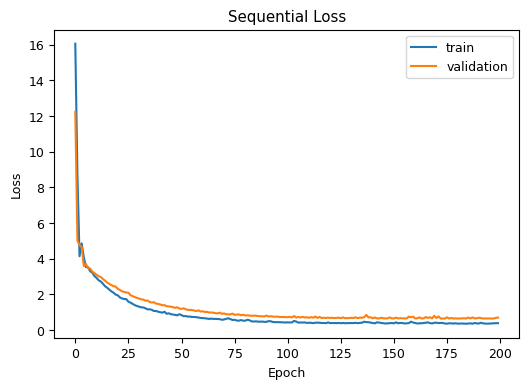

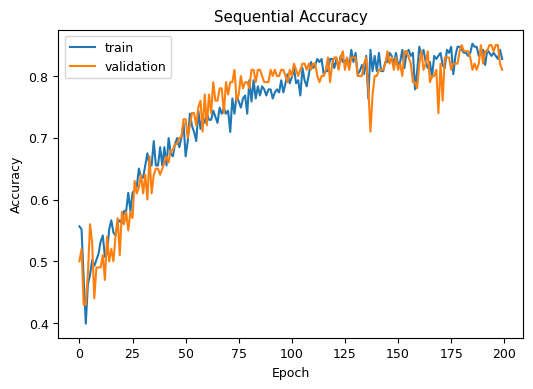

In [ ]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Sequential Loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Sequential Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

## catboost classsification

In [ ]:
cat_model = cat.CatBoostClassifier(
    iterations=2000,
    verbose=0,
    grow_policy='SymmetricTree',
    learning_rate=0.035,
    colsample_bylevel=0.8,
    max_depth=5,
    l2_leaf_reg=0.2,
    subsample=0.70,
    max_bin=4096,
    custom_loss=['AUC', 'Accuracy']
)

In [ ]:
cat_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=False)
print(cat_model.get_best_score())

{'learn': {'Accuracy': 1.0, 'Logloss': 0.0011482391970856155}, 'validation': {'Accuracy': 0.87, 'Logloss': 0.37303080324255655, 'AUC': 0.9263705482192877}}


## SVM

Meilleurs paramètres trouvés :
{'svc__C': 1, 'svc__gamma': 'scale', 'svc__kernel': 'linear'}
Accuracy: 0.88
Precision: 0.8775510204081632
Recall: 0.8775510204081632
F1 Score: 0.8775510204081631
Confusion Matrix:


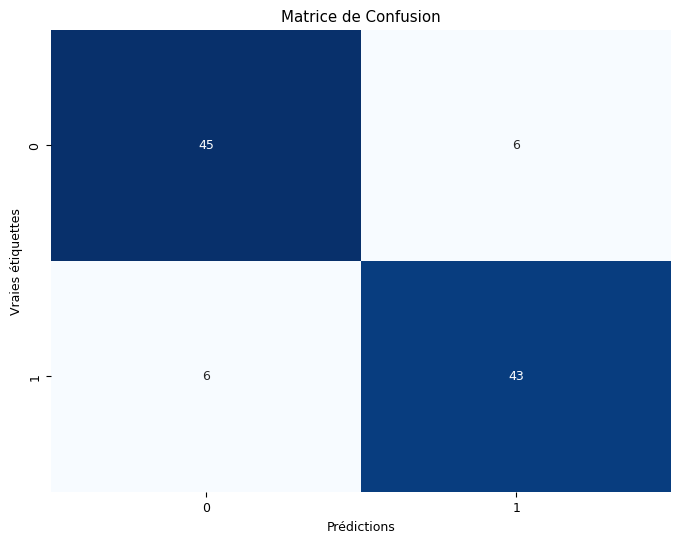

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88        51
           1       0.88      0.88      0.88        49

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100



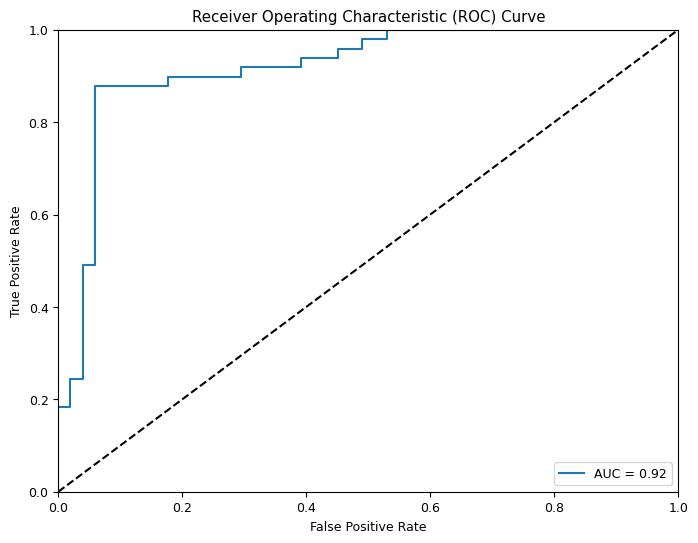

In [ ]:
# Création d'un pipeline avec standardisation et SVM
pipeline = make_pipeline(StandardScaler(), SVC())

# Définition de la grille des hyperparamètres à tester
param_grid = {
    'svc__C': [0.1, 1, 10, 100],
    'svc__kernel': ['linear', 'rbf', 'poly'],
    'svc__gamma': ['scale', 'auto']
}

# Recherche en grille avec validation croisée
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')  # Utilisation de la F1-score comme métrique de scoring
grid_search.fit(X_train, y_train.ravel())

# Affichage des meilleurs paramètres
print("Meilleurs paramètres trouvés :")
print(grid_search.best_params_)

# Meilleur modèle
best_model = grid_search.best_estimator_

# Performances du meilleur modèle
y_pred_svm = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm)
recall = recall_score(y_test, y_pred_svm)
f1 = f1_score(y_test, y_pred_svm)
confusion = confusion_matrix(y_test, y_pred_svm)
report = classification_report(y_test, y_pred_svm)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

print("Confusion Matrix:")
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion")
plt.show()

print("Classification Report:")
print(report)

# Calcul des courbes ROC et de l'AUC
y_pred_proba = best_model.decision_function(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()



## SVM ensemble
Vous pouvez utiliser une approche d'ensemble, telle que le Bagging ou le Boosting, avec des classificateurs SVM de base.

Accuracy: 0.84
Precision: 0.8235294117647058
Recall: 0.8571428571428571
F1 Score: 0.84


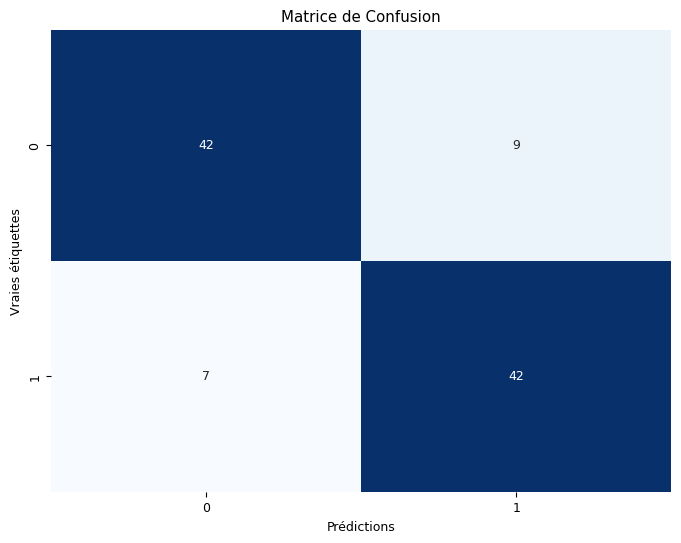

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        51
           1       0.82      0.86      0.84        49

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



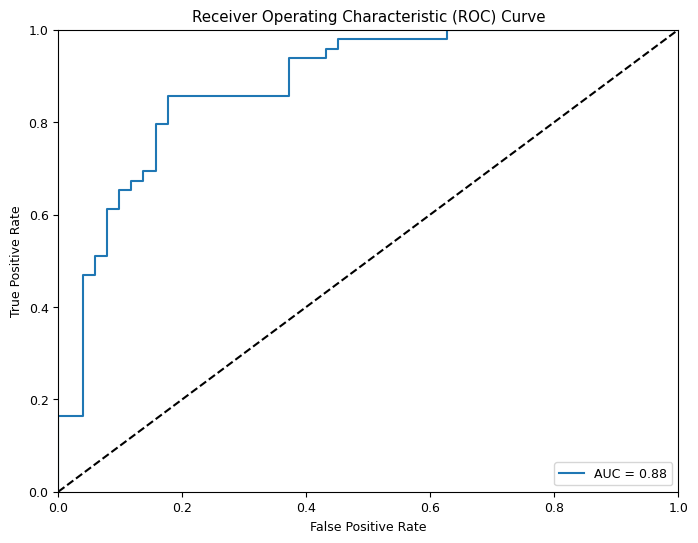

In [ ]:
import warnings
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Ignorer les avertissements spécifiques
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

# Création d'un classificateur SVM de base
base_classifier = make_pipeline(StandardScaler(), SVC())

# Création d'un GradientBoostingClassifier avec le classificateur SVM de base
gb_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)  # Vous pouvez ajuster le nombre d'estimateurs ici

# Entraînement du modèle GradientBoostingClassifier
gb_classifier.fit(X_train, y_train.ravel())  # Enlever l'équilibrage des classes ici

# Performances du modèle
y_pred_svm_gb_ensemble = gb_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred_svm_gb_ensemble)
precision = precision_score(y_test, y_pred_svm_gb_ensemble)
recall = recall_score(y_test, y_pred_svm_gb_ensemble)
f1 = f1_score(y_test, y_pred_svm_gb_ensemble)
confusion = confusion_matrix(y_test, y_pred_svm_gb_ensemble)
report = classification_report(y_test, y_pred_svm_gb_ensemble)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Tracé de la matrice de confusion sous forme de graphique
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion")
plt.show()

print("Classification Report:")
print(report)

# Calcul des courbes ROC et de l'AUC
y_pred_proba = gb_classifier.predict_proba(X_test)[:, 1]  # Probabilité de la classe positive
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


Accuracy: 0.84
Precision: 0.8403361344537814
Recall: 0.8403361344537814
F1 Score: 0.84


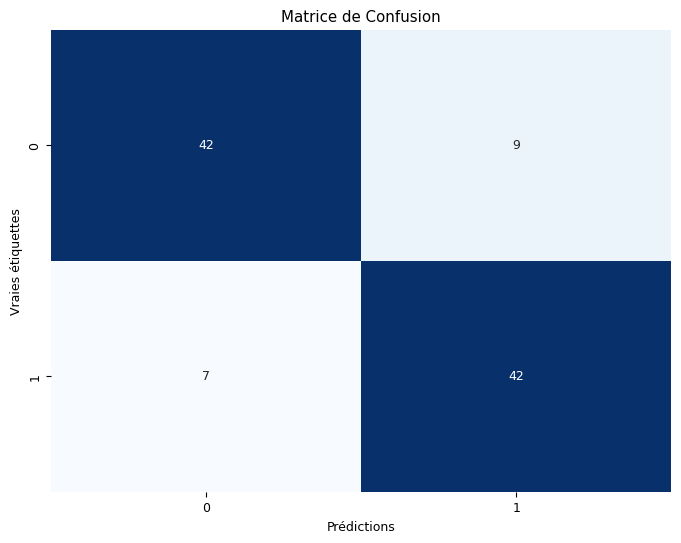

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        51
           1       0.82      0.86      0.84        49

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



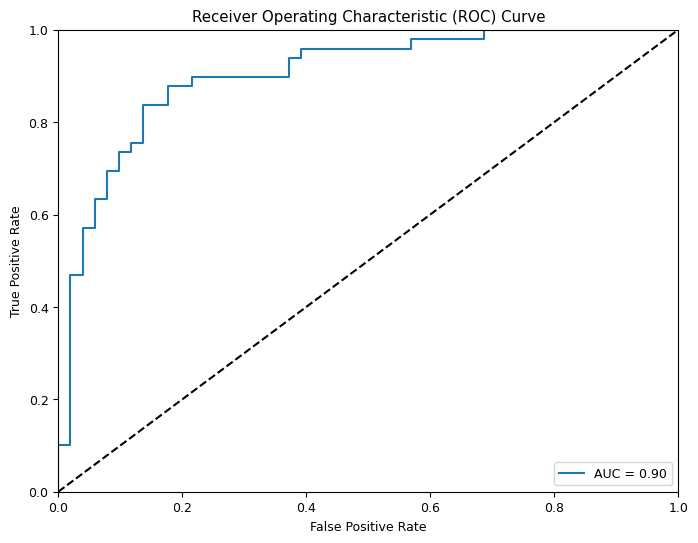

In [ ]:
# Création d'un pipeline avec standardisation et SVM
svc_pipeline = make_pipeline(StandardScaler(), SVC(probability=True))

# Création du Bagging Classifier avec des SVM
bagging_clf = BaggingClassifier(base_estimator=svc_pipeline, n_estimators=10, random_state=0)

# Entraînement du modèle sur les données d'entraînement
bagging_clf.fit(X_train, y_train.ravel())

# Prédictions sur les données de test
y_pred_svm_ensemble = bagging_clf.predict(X_test)

# Calcul et affichage des différentes métriques d'évaluation
accuracy = accuracy_score(y_test, y_pred_svm_ensemble)
precision = precision_score(y_test, y_pred_svm_ensemble, average='macro')
recall = recall_score(y_test, y_pred_svm_ensemble, average='macro')
f1 = f1_score(y_test, y_pred_svm_ensemble, average='macro')
confusion = confusion_matrix(y_test, y_pred_svm_ensemble)
report = classification_report(y_test, y_pred_svm_ensemble)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Tracé de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Prédictions")
plt.ylabel("Vraies étiquettes")
plt.title("Matrice de Confusion")
plt.show()

print("Classification Report:")
print(report)

# Calcul des courbes ROC et de l'AUC
y_pred_proba = bagging_clf.predict_proba(X_test)[:, 1]  # Modification pour BaggingClassifier
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
